# Backtesting trading strategy
#### Strategy: Select top k stocks based on the predicted probabilities by the trained LSTM model.
#### Metric: Accuracy (accuracy greater than 50% can be profitable with high-frequency trading due to the stock market volatility)
#### Test period: 20 days (model needs retraining for future days by a rolling window training approach)

**Load modules**

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, accuracy_score
from sklearn.metrics import matthews_corrcoef
import matplotlib.pyplot as plt
import pickle
import os

2025-02-12 21:26:45.007337: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-12 21:26:46.045311: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


**Create the LSTM test dataset with selected technical indicators**

In [2]:
features_list = ['vol_adj_rtn_12m', 'd130_min_rtn', 'stochastic_k', 'stochastic_d', 'stochastic_k_20', 'stochastic_d_20',
       'adj_sto_6m_k', 'adj_sto_6m_d', 'std_dev_20', 'stderr_180d', 'ann_vol_1m', 'ann_vol_12m', 'vol_signal_5d', 'vol_signal_50d',
       'm24_res_rtn_var', 'd90_cv', 'd60_cv', 'vol_style', 'pm_1m', 'pm_5d', 'pm_6m', 'pm_9m', 'pm_12m', 'pm_12m1m', 'prc_to_260dl', 
        'prc_to_52wh', 'pratio_15_36w', 'ratio_50_to_200', 'pm_style', 'pa52wl20dlag', 'w39_rtn_lag4w', 'osc_4to52w_prc', 'hl_1m', 
        'hl_52w', 'log_unadj_price', 'rsi_14', 'rsi_26w', 'd10_macd', 'd10_macd_signal', 'slope_52w', 'pslope_serr_26w', 'sma_10',
        'sma_50', 'sma_200', 'bollinger_upper', 'bollinger_middle', 'bollinger_lower', 'adx', 'd5_money_flow', 'd5_money_flow_vol', 
        'amihud', 'chg_1y_amihud', 'obv', 'beta_60m', 'alpha_60m', 'alpha_18m_6mchg', 'alpha_12m_6mchg', 'alpha_36m_6mchg', 
        'rel_pr_str_12m', 'sharpe_60d']

In [3]:
year = 2022
counter = 1
data_dir = os.path.join("../data", str(year))
test_data_labelled_path = os.path.join(data_dir, f"LSTM_test_{counter}.pkl")
test_data_labelled = pd.read_pickle(test_data_labelled_path)
test_data_labelled = test_data_labelled[test_data_labelled['date']>'2022-01-1']

In [4]:
def create_lstm_test_dataset(df, feature_list, sequence_length=15):
    X, y, metadata = [], [], [] 
    for _, stock_data in df.groupby('ticker', group_keys=False):
        stock_data = stock_data.reset_index(drop=True)
        feature_array = stock_data[feature_list].values
        label_array = stock_data['label'].values
        for i in range(len(stock_data) - sequence_length):
            X.append(feature_array[i:i+sequence_length])  
            y.append(label_array[i + sequence_length]) 
            metadata.append(stock_data.iloc[i + sequence_length][['date', 'ticker', 'open', 'high', 'low', 'close', 'return', 'adj_close', 'sp500_close', 'sp500_return', 'risk_free_rate', 'return3D', 'label']].values)
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.int8), pd.DataFrame(metadata, columns=['date', 'ticker', 'open', 'high', 'low', 'close', 'return', 'adj_close', 'sp500_close', 'sp500_return', 'risk_free_rate', 'return3D', 'label'])
X_test, y_test, metadata_test = create_lstm_test_dataset(test_data_labelled, features_list)

**Load the trained model**

In [5]:
model_path = os.path.join(data_dir, f"LSTM_model_{counter}_3D.keras")
with tf.device('/CPU:0'):
    model = tf.keras.models.load_model(model_path)

2025-02-12 21:26:48.796348: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-12 21:26:48.820716: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-12 21:26:48.820966: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [6]:
with tf.device('/CPU:0'):
    y_pred_probs = model.predict(X_test) 

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step   


**Compute metrics on the test set and plot ROC curve**

Accuracy: 0.5543
Precision: 0.5493
Recall: 0.6051
F1 Score: 0.5758
ROC AUC: 0.5543
MCC Score: 0.1092


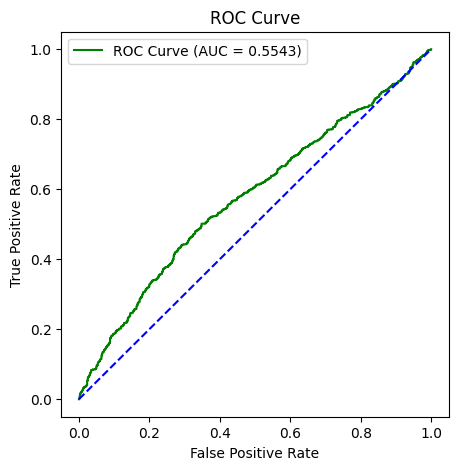

In [7]:
y_pred = (y_pred_probs > 0.5).astype(int) 

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {auc:.4f}")
print(f"MCC Score: {mcc:.4f}")

fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.4f})", color='green')
plt.plot([0,1], [0,1], linestyle='--', color='blue') 
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

**Measure excess return = return obtained by selecting top k stocks - return obtained by selecting all stocks which is equivalent to S&P500 returns (ignoring de-listed stocks)**

In [8]:
test_df = pd.DataFrame({
    "date": metadata_test["date"].values,  
    "ticker": metadata_test["ticker"].values,
    "risk_free_rate": metadata_test["risk_free_rate"].values,
    "return3D": metadata_test["return3D"].values,
    "label": metadata_test["label"].values,
    "pred_prob": y_pred_probs.flatten()
})

In [9]:
dates_list = test_df['date'].unique()
top_stock_return_list = []
all_stock_return_list = []
for d in dates_list:
    day_df = test_df[test_df['date']==d]
    all_stock_return_list.append(day_df['return3D'].mean())
    top_stocks = day_df.nlargest(1, 'pred_prob')
    top_stock_return_list.append(top_stocks['return3D'].mean())

In [10]:
excess_return = sum(top_stock_return_list) - sum(all_stock_return_list)
print("Excess return S&P500: ", excess_return*100, '%')

Excess return S&P500:  11.488841260070021 %
